In [1]:
from pathlib import Path

# Get the current working directory as a Path object
current_path = Path.cwd()
home_folder = 'evan_home'

# Traverse up the directory tree until you find the target folder
for parent in [current_path] + list(current_path.parents):
    if parent.name == home_folder:
        home_path = parent
        break
else:
    raise ValueError(f"Folder '{home_folder}' not found in the current working directory.")

print("Home Path:", home_path)
source_code_dir = home_path / 'Source_code'
dataset_dir = home_path / 'Dataset'


Home Path: c:\Users\evanlee\Documents\Bmi_NAS_evan\evan_home


In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

sys.path.append(str(source_code_dir))
from ADlasso2 import AD2_w_utils_lossdiff_noZ as ad

## Ignore section lambda decision
(Feature 數量為零之後的lambda就不要了)

In [3]:
os.chdir(source_code_dir / 'HCC_case_study/tuning_leiden')

In [11]:
def ignore_section_lambda_decision(tuning_dict, celltype, k_seg, start_idx=0, version='new', output_dir=''):
    if version == 'new':
        # convert tuning_dict to old format
        tuning_old_format = {}
        for outer_key in tuning_dict.keys():
            for inner_key, value in tuning_dict[outer_key].items():
                if inner_key not in tuning_old_format.keys():
                    tuning_old_format[inner_key] = []
                tuning_old_format[inner_key].append(value)
    else:
        tuning_old_format = tuning_dict

    for key in tuning_old_format.keys():
        tuning_old_format[key] = np.array(tuning_old_format[key])
    
    # start index should be the index of lambda at which the BCE curve does not look strange
    if start_idx > 0:
        print('Start index:', start_idx)
    # Find the index of feature_number start to become 0
    cut_idx = len(tuning_old_format['Feature_number'])
    for i in range(len(tuning_old_format['Feature_number'])):
        if tuning_old_format['Feature_number'][i] <= 1:
            cut_idx = i
            print('Cut index:', cut_idx)
            break

    trimmed_tuning = {}
    for k in tuning_old_format.keys():
        trimmed_tuning[k] = tuning_old_format[k][start_idx:cut_idx]

    def plot_lambda_decision(tuning, celltype, opt_lmbd, cut_idx, start_idx=0, savepath=''):
        fig, ax1 = plt.subplots(figsize = (8, 5))
        ax2 = ax1.twinx()

        line1, = ax1.plot(np.exp(tuning['log_lambda_range']), tuning['loss_history'], marker='o', color='blue')
        line2, = ax2.plot(np.exp(tuning['log_lambda_range']), tuning['Feature_number'], marker='o', color='orange')
        ax1.set(xscale="log")

        # vertical line for optimal lambda
        plt.axvline(x=opt_lmbd, color = 'black', linestyle=':')
        
        # vertical line for start lambda (blue)
        if start_idx > 0:
            # only plot the start line when the start_idx is not the first index
            print('Start:', np.exp(tuning['log_lambda_range'][start_idx]))
            # vertical line for start lambda
            plt.axvline(x=np.exp(tuning['log_lambda_range'][start_idx]), color = 'blue', linestyle=':')
        # vertical line for cut lambda (red)
        if cut_idx < len(tuning['log_lambda_range']):
            # only plot the cut line when the cut_idx is not the last index
            print('Cut:', np.exp(tuning['log_lambda_range'][cut_idx]))
            # vertical line for cut lambda
            plt.axvline(x=np.exp(tuning['log_lambda_range'][cut_idx]), color = 'red', linestyle=':')
        
        # horizontal line for feature number = 0 (this does not make sense with y log scale)
        # plt.axhline(y=0, color = 'black', linestyle='--')

        ax1.set_xlabel(f"lambda (optimal: {opt_lmbd})")
        ax1.set_ylabel("Loss"); ax2.set_ylabel("Feature number")
        ax2.set_yscale("log")  # set log scale for feature number
        ax2.set_ylim(bottom=0.5, top=None)  # set ylim for feature number  # EDITTED
        ax1.set_title(f'{celltype} lambda decision')
        plt.legend(handles=[line1, line2], labels=['BCE loss', 'Feature_number'], loc='upper left')

        if savepath:
            plt.savefig(savepath, dpi=300)

    # Lambda decision from trimmed tuning result
    # TODO: reset k value of lambda decision
    opt_lmbd, candidates, fig, segment_variables = ad.lambda_decision(trimmed_tuning, k=k_seg, savepath=os.path.join(output_dir, f'{celltype}_k{k_seg}_lambda_decision_trimmed.png'))
    print('Optimal lambda:', opt_lmbd)
    log_opt_lmbd = np.log(opt_lmbd)

    log_lambda_range = tuning_old_format['log_lambda_range']
    opt_idx = np.where(log_lambda_range == log_opt_lmbd)[0][0]

    feature_no_celltype = int(tuning_old_format['Feature_number'][opt_idx])
    print('Feature no:', feature_no_celltype)

    # Plot lambda vs. prevalence and lambda vs. loss
    plot_lambda_decision(tuning_old_format, celltype, opt_lmbd, cut_idx, start_idx=start_idx, savepath=os.path.join(output_dir, f'{celltype}_k{k_seg}_lambda_decision_all.png'))

    return opt_lmbd, feature_no_celltype

In [5]:
types = ['B', 'Endothelial', 'Fibroblast', 'Hepatocyte', 'Myeloid', 'T_NK']
types

['B', 'Endothelial', 'Fibroblast', 'Hepatocyte', 'Myeloid', 'T_NK']

In [12]:
### Function for running lambda decision for a single cell types
def run_lmbd_decision(celltype, k_seg, start_idx=0, output_dir=''):
    tuning_file = f'{celltype}_tuning.json'
    if not os.path.exists(tuning_file):
        print(f"File {tuning_file} does not exist. Skipping to the next cluster.")
        return

    print('====================')
    print(f'Cell type: {celltype}')
    with open(tuning_file) as f:
        tuning = json.load(f)

    opt_lmbd, feature_no_celltype = ignore_section_lambda_decision(tuning, celltype, k_seg=k_seg, start_idx=start_idx, version='old', output_dir=output_dir)
    # opt_lmbd_dict[celltype] = opt_lmbd
    # feature_no_dict[celltype] = feature_no_celltype
    return opt_lmbd, feature_no_celltype

## k = 3

B Start index: 0
Cell type: B
Optimal lambda: 0.004641588833612781
Feature no: 25
Endothelial Start index: 0
Cell type: Endothelial
Optimal lambda: 0.0014677992676220694
Feature no: 44
Fibroblast Start index: 0
Cell type: Fibroblast
Optimal lambda: 0.0014677992676220694
Feature no: 36
Hepatocyte Start index: 0
Cell type: Hepatocyte
Optimal lambda: 0.014677992676220709
Feature no: 19
Myeloid Start index: 0
Cell type: Myeloid
Optimal lambda: 0.003162277660168382
Feature no: 51
T_NK Start index: 0
Cell type: T_NK
Optimal lambda: 0.006812920690579613
Feature no: 36


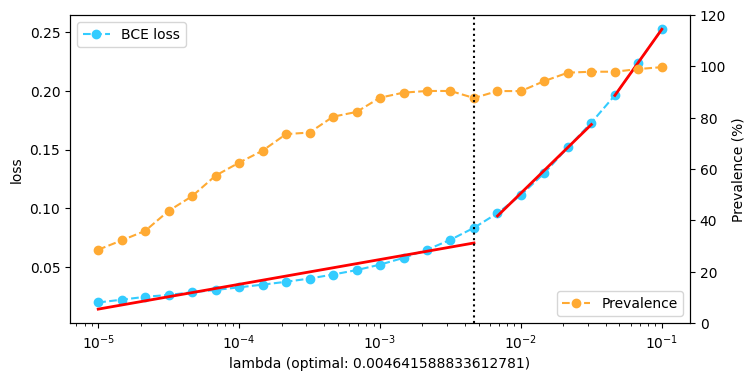

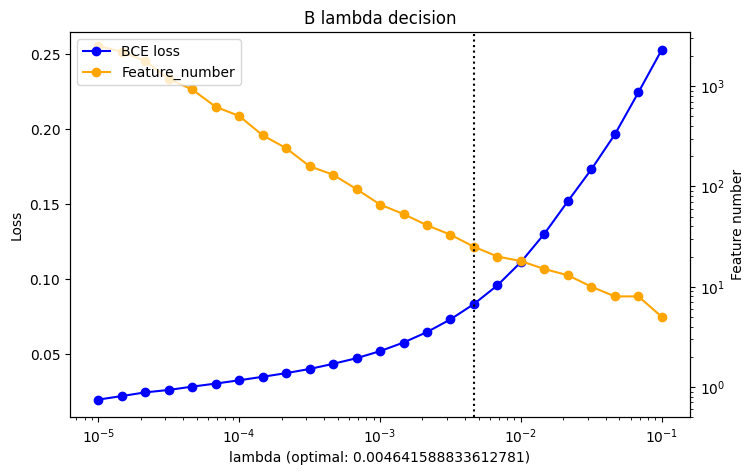

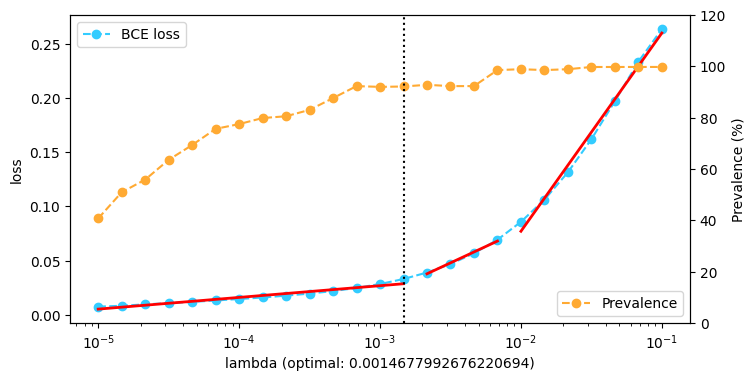

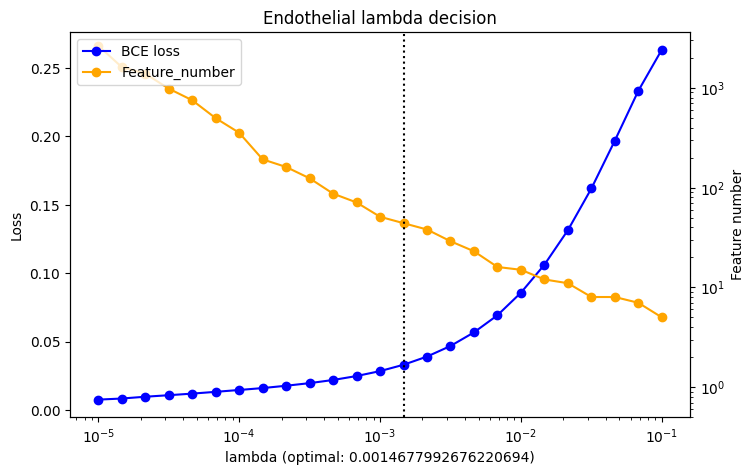

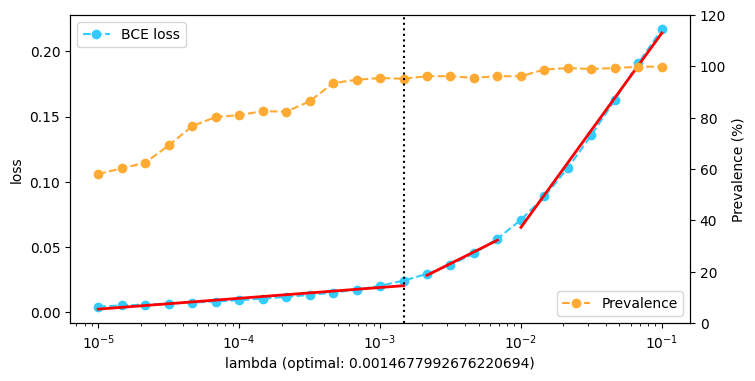

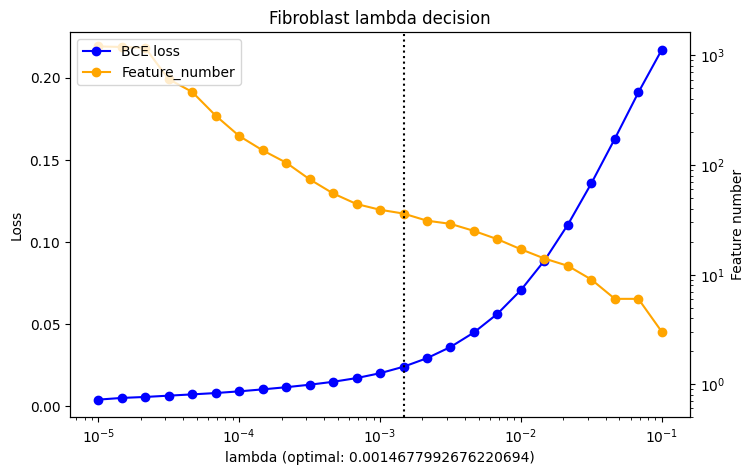

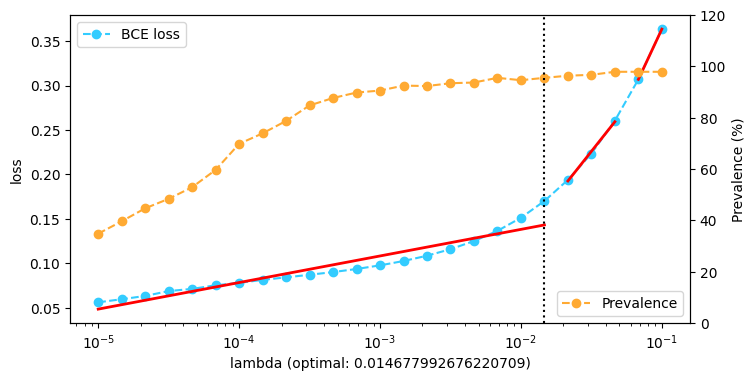

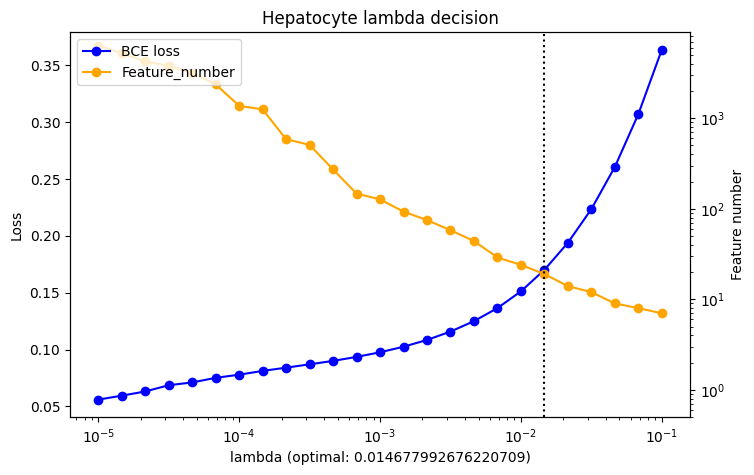

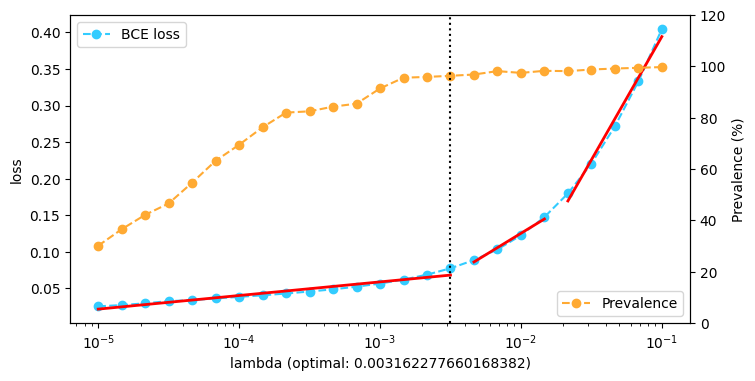

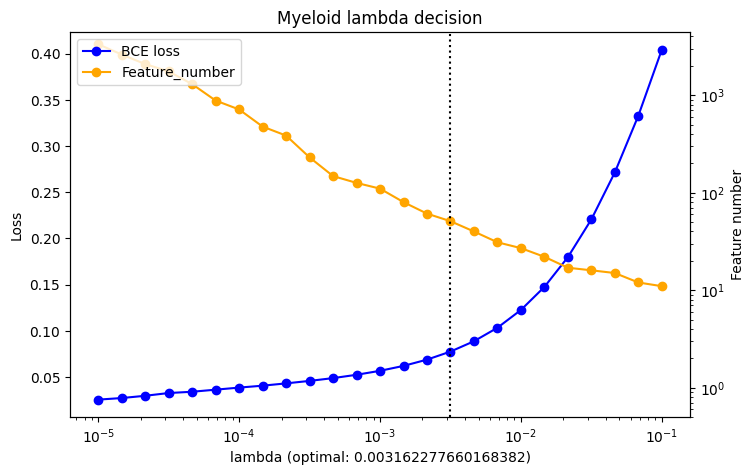

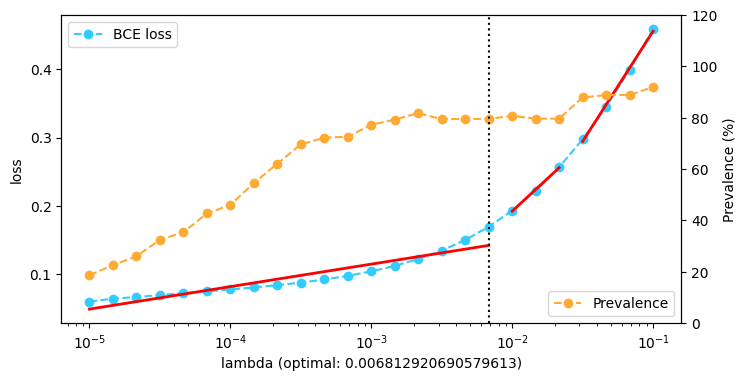

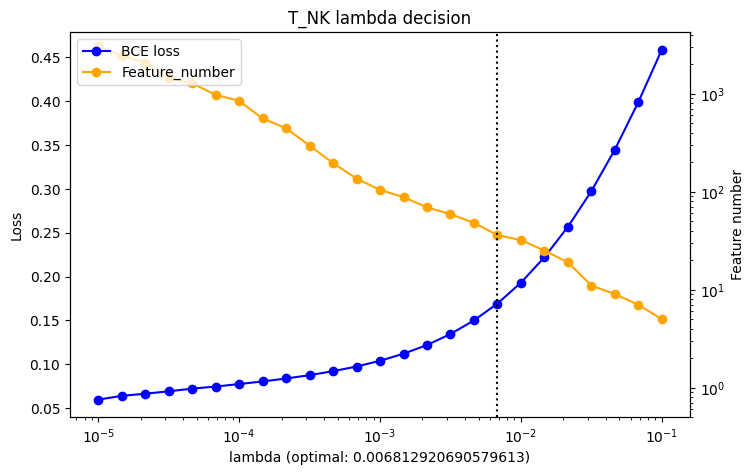

In [13]:
os.chdir(source_code_dir / 'HCC_case_study/tuning_celltype/celltype_tuning_result')

# Start index for each cell type
start_idx_dict = {
    
}
opt_lmbd_dict_k3 = {}
feature_no_dict_k3 = {}

dir = source_code_dir / r'HCC_case_study\tuning_celltype\lambda_decision_celltype_k3'
for celltype in types:
    start_idx = start_idx_dict.get(celltype, 0)
    print('====================')
    print(celltype, 'Start index:', start_idx)
    opt_lmbd_dict_k3[celltype], feature_no_dict_k3[celltype] = run_lmbd_decision(celltype, k_seg=3, start_idx=start_idx, output_dir=dir)
    # try:
    #     opt_lmbd_dict_k3[celltype], feature_no_dict_k3[celltype] = run_lmbd_decision(celltype, k_seg=3, start_idx=start_idx, output_dir=dir)
    # except:
    #     print('Skipping', celltype)

In [14]:
opt_lmbd_dict_k3

{'B': 0.004641588833612781,
 'Endothelial': 0.0014677992676220694,
 'Fibroblast': 0.0014677992676220694,
 'Hepatocyte': 0.014677992676220709,
 'Myeloid': 0.003162277660168382,
 'T_NK': 0.006812920690579613}

In [15]:
feature_no_dict_k3

{'B': 25,
 'Endothelial': 44,
 'Fibroblast': 36,
 'Hepatocyte': 19,
 'Myeloid': 51,
 'T_NK': 36}

In [16]:
os.chdir(source_code_dir / 'HCC_case_study/tuning_celltype')

In [17]:
with open('c_celltype_k3_opt_lmbd.json', 'w') as f:
    json.dump(opt_lmbd_dict_k3, f)